In [2]:
from sys import version
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from os.path import basename, dirname
print(version)

3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [190]:
all_perf = pd.read_csv("batch_compare.tsv", sep='\t')
perf_weights = all_perf.copy()
all_perf['agg_level'] = all_perf['batch'].apply(lambda x: '15m' if '15m' in x else '30m')
all_perf['model'] = all_perf['batch'].apply(lambda x: x.split('_')[0] + '/'+ x.split('_')[2])
ns = all_perf.groupby(['agg_level', 'batch', 'group'])['n'].max().reset_index()
all_perf = all_perf.pivot_table(index=['group', 'agg_level'], columns='model', values='mae')
all_perf = all_perf.reset_index().sort_values(['agg_level', 'group'])
#all_perf = all_perf.set_index('group')

all_perf.head()

model,group,agg_level,nn/combined,nn/summer,nn/winter,svm/combined,svm/summer,svm/winter,xgb/combined,xgb/summer,xgb/winter
0,Conventional Type,15m,6.470694,7.396394,6.436952,20.843963,11.051643,9.328277,8.138904,8.732963,NaN
2,EW route,15m,7.061428,8.303957,7.387408,28.224602,12.512284,10.870334,9.589530,10.012008,NaN
4,Early Morning,15m,5.011329,5.820263,5.475470,22.016050,10.506821,9.336869,7.539040,8.402142,NaN
6,East King County Region,15m,3.688738,4.815563,3.046181,6.297624,8.098701,4.835428,4.798142,5.806357,NaN
8,Evening Peak,15m,8.248627,9.610420,7.965389,18.368434,13.831155,11.337762,10.202344,11.027818,NaN


In [174]:
ns = ns.drop_duplicates()
ns['type'] = ns['batch'].apply(lambda x: x.rsplit('_',2)[-1])
ns = ns[['agg_level', 'type', 'group', 'n']].drop_duplicates()
ns.head()

,agg_level,type,group,n
0,15m,combined,Conventional Type,53849
1,15m,combined,EW route,15931
2,15m,combined,Early Morning,1608
3,15m,combined,East King County Region,10059
4,15m,combined,Evening Peak,14190


In [175]:
desired_index_order = [
    'Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Night',

    'Weekend Morning', 'Weekend Peak', 'Weekend Evening',

    'Conventional Type', 'Trolley Type',

    'NS route', 'EW route',

    'Express Region', 'East King County Region', 'North King County Region', 
        'Seattle Region', 'South King County Region',

    'RapidRide', 'Non-RapidRide',

    'Winter', 'Summer',

    'Weekday', 'Weekend'

    'high frequency route', 'med frequency route', 'low frequency route',
]
perf15 = pd.DataFrame()
perf30 = pd.DataFrame()
for i, name in enumerate(desired_index_order):
    mod = all_perf.loc[(all_perf['group'] == name) & (all_perf['agg_level'] == '15m'),]
    n = ns.loc[(ns['group'] == name) & (ns['agg_level'] == '15m') & (ns['type']=='combined'), 'n'].values
    if len(n) > 0:
        n=n[0]
    else:
        n=0
    mod['label'] = f'{name}\nn={n}'
    perf15 = pd.concat([
        perf15,
        mod
    ])

for i, name in enumerate(desired_index_order):
    mod = all_perf.loc[(all_perf['group'] == name) & (all_perf['agg_level'] == '30m'),]
    n = ns.loc[(ns['group'] == name) & (ns['agg_level'] == '30m') & (ns['type']=='combined'), 'n'].values
    if len(n) > 0:
        n=n[0]
    else:
        n=0
    mod['label'] = f'{name}\nn={n}'
    perf30 = pd.concat([
        perf30,
        mod
    ])

perf15.set_index('label', inplace=True)
perf30.set_index('label', inplace=True)

In [97]:
perf15.head()

model,group,agg_level,nn/combined,nn/summer,nn/winter,svm/combined,svm/summer,svm/winter,xgb/combined,xgb/summer,xgb/winter
label,,,,,,,,,,,
Early Morning\nn=923,Early Morning,15m,5.011329,5.820263,5.475470,22.016050,10.506821,9.336869,7.539040,8.402142,NaN
Morning Peak\nn=10040,Morning Peak,15m,6.593124,7.766696,6.456719,17.145276,11.540443,9.293873,8.689217,9.362403,NaN
Midday\nn=8551,Midday,15m,6.500403,7.322627,6.288385,19.480044,11.512655,9.628759,7.894685,8.443080,NaN
Evening Peak\nn=8386,Evening Peak,15m,8.248627,9.610420,7.965389,18.368434,13.831155,11.337762,10.202344,11.027818,NaN
Night\nn=5008,Night,15m,4.711781,5.547193,4.437071,19.757242,9.116357,6.057894,6.263290,7.153786,NaN


In [121]:
import seaborn as sns

sns.barplot(x="time", hue="kind", y="data", data=perf15)

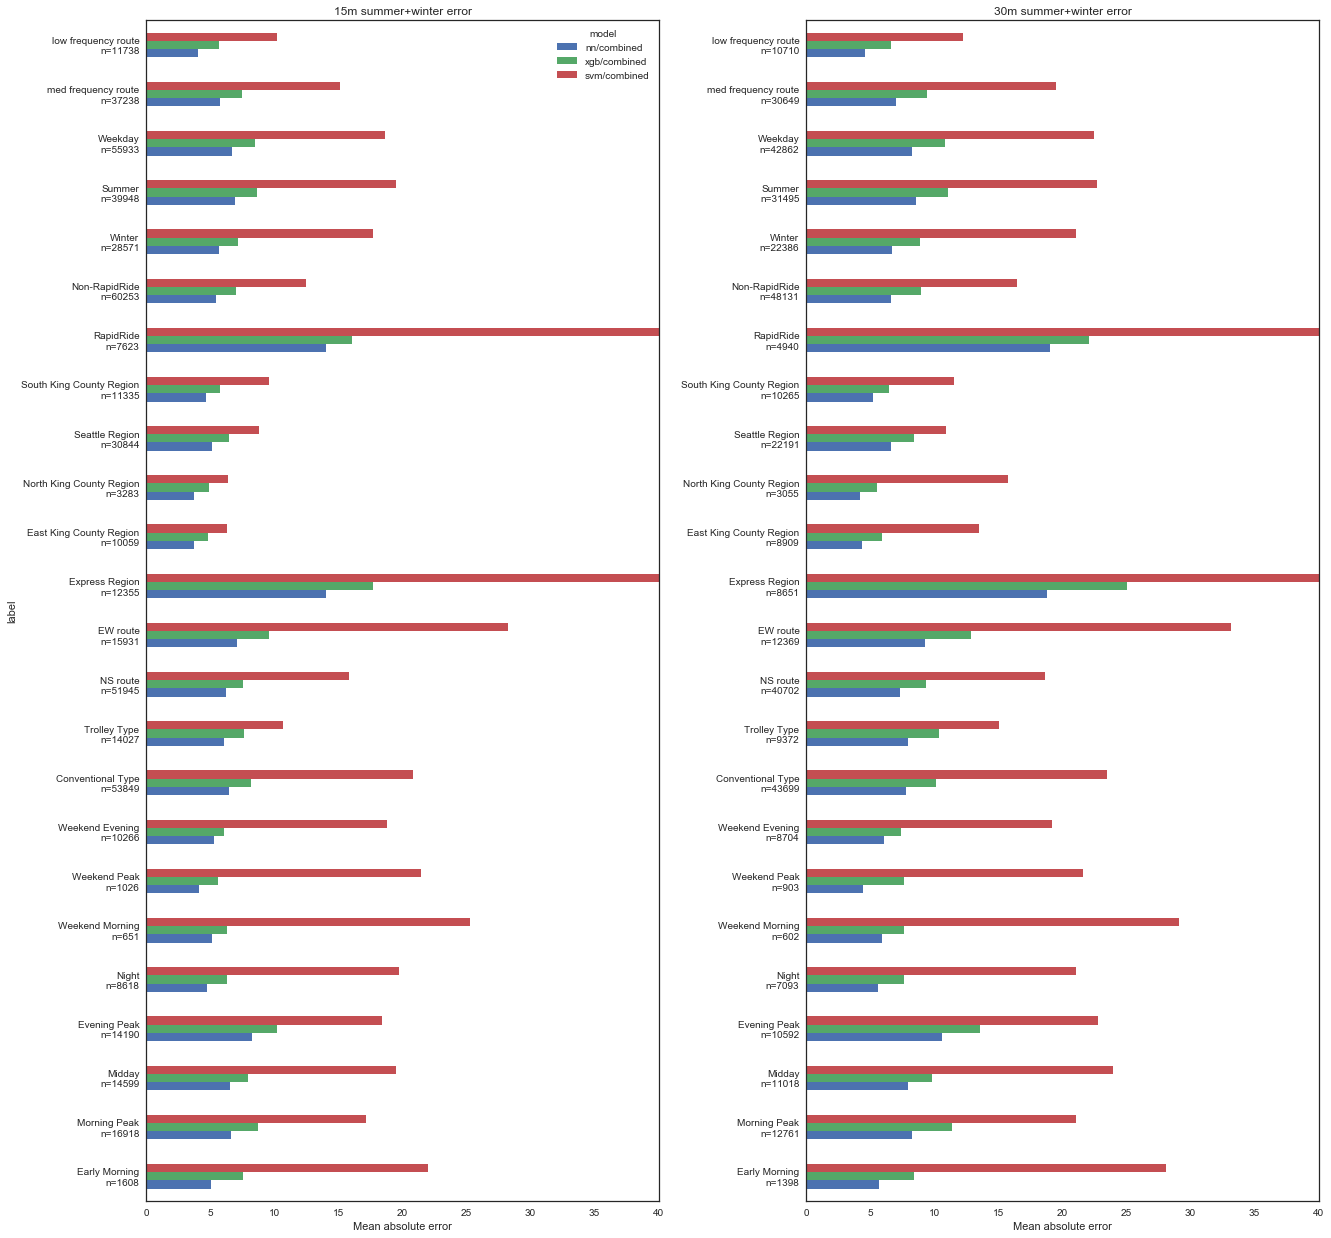

In [162]:
plt.style.use('seaborn-white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
fig.tight_layout(pad=12)

shared_xlim=(0,40)

# set desired order of svm, xgb, nn
columns = ['svm/combined', 'svm/summer', 'svm/winter', 
            'xgb/combined','xgb/summer', 'xgb/winter',
            'nn/combined', 'nn/summer', 'nn/winter'][::-1]

cols = [c for c in columns if 'combined' in c]

perf15[cols].plot.barh(
   rot=0, 
   ax=axes[0], 
   title="15m summer+winter error", 
   align='center', 
   xlim=shared_xlim)

perf30[cols].plot.barh(
    rot=0, 
    ax=axes[1], 
    title="30m summer+winter error", 
    legend=False, 
    align='center', 
    xlim=shared_xlim)

axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[1].set_ylabel('')
plt.show()

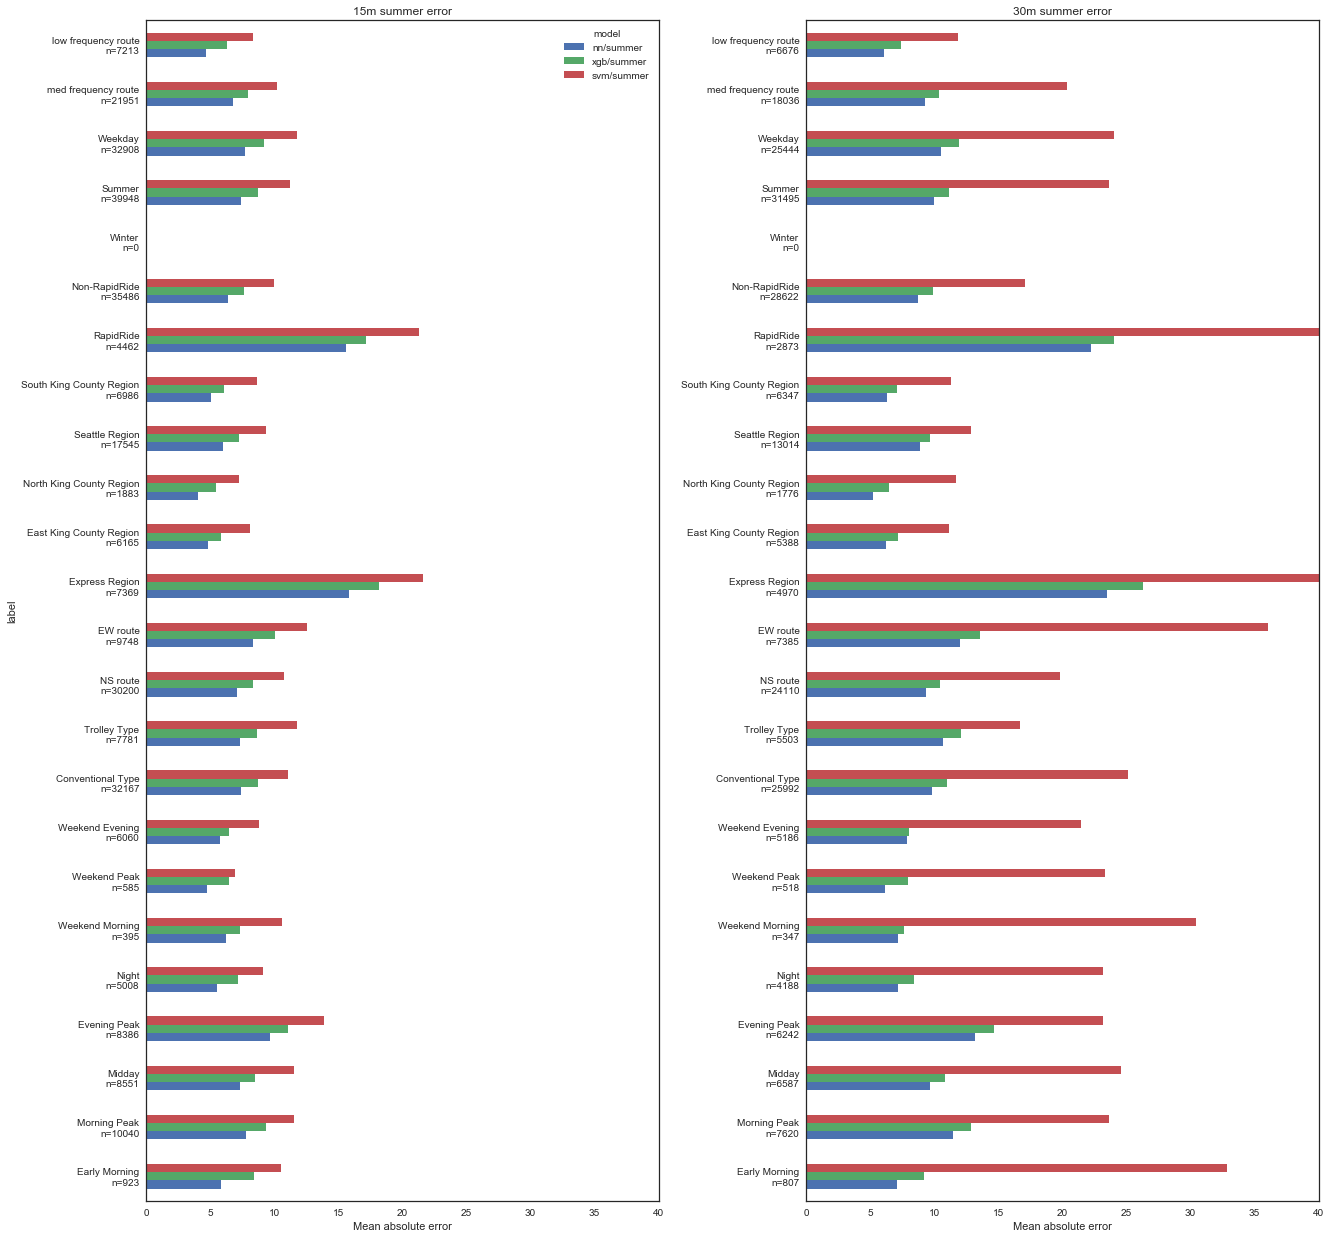

In [176]:
perf15 = pd.DataFrame()
perf30 = pd.DataFrame()
for i, name in enumerate(desired_index_order):
    mod = all_perf.loc[(all_perf['group'] == name) & (all_perf['agg_level'] == '15m'),]
    n = ns.loc[(ns['group'] == name) & (ns['agg_level'] == '15m') & (ns['type']=='summer'), 'n'].values
    if len(n) > 0:
        n=n[0]
    else:
        n=0
    mod['label'] = f'{name}\nn={n}'
    perf15 = pd.concat([
        perf15,
        mod
    ])

for i, name in enumerate(desired_index_order):
    mod = all_perf.loc[(all_perf['group'] == name) & (all_perf['agg_level'] == '30m'),]
    n = ns.loc[(ns['group'] == name) & (ns['agg_level'] == '30m') & (ns['type']=='summer'), 'n'].values
    if len(n) > 0:
        n=n[0]
    else:
        n=0
    mod['label'] = f'{name}\nn={n}'
    perf30 = pd.concat([
        perf30,
        mod
    ])

perf15.set_index('label', inplace=True)
perf30.set_index('label', inplace=True)

plt.style.use('seaborn-white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
fig.tight_layout(pad=12)

cols = [c for c in columns if 'summer' in c]
perf15[cols].plot.barh(
   rot=0, 
   ax=axes[0], 
   title="15m summer error", 
   align='center', 
   xlim=shared_xlim)

perf30[cols].plot.barh(
    rot=0, 
    ax=axes[1], 
    title="30m summer error", 
    legend=False, 
    align='center', 
    xlim=shared_xlim)

axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[1].set_ylabel('')
plt.show()

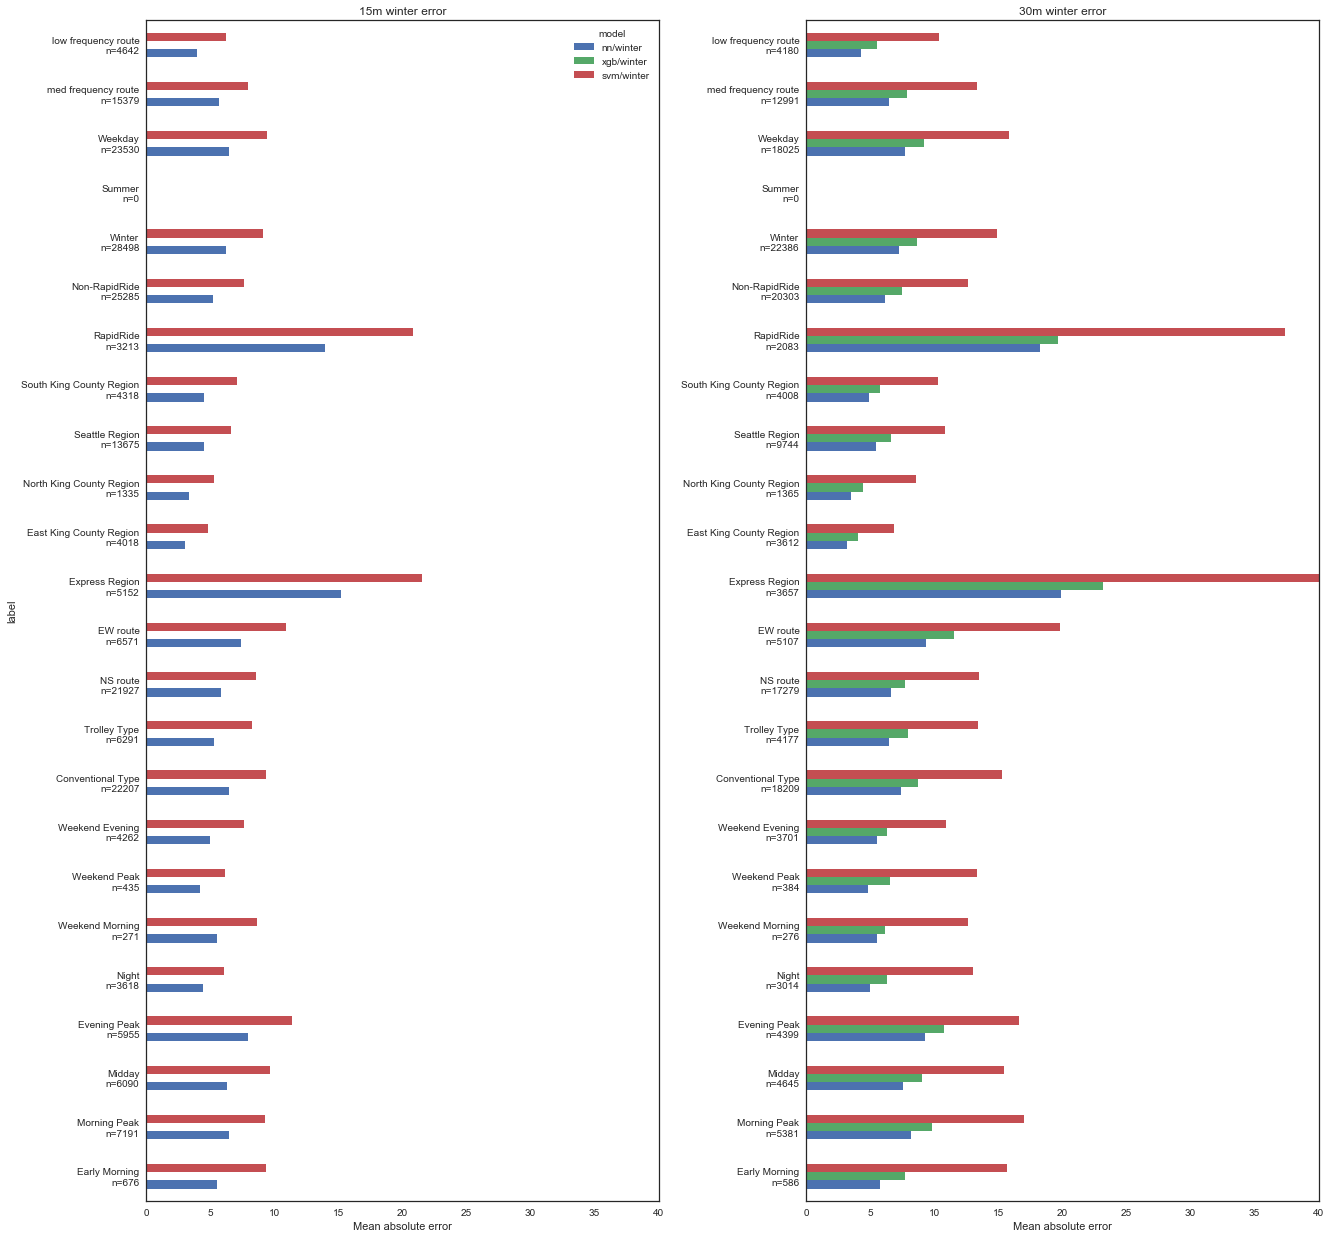

In [177]:


perf15 = pd.DataFrame()
perf30 = pd.DataFrame()
for i, name in enumerate(desired_index_order):
    mod = all_perf.loc[(all_perf['group'] == name) & (all_perf['agg_level'] == '15m'),]
    n = ns.loc[(ns['group'] == name) & (ns['agg_level'] == '15m') & (ns['type']=='winter'), 'n'].values
    if len(n) > 0:
        n=n[0]
    else:
        n=0
    mod['label'] = f'{name}\nn={n}'
    perf15 = pd.concat([
        perf15,
        mod
    ])

for i, name in enumerate(desired_index_order):
    mod = all_perf.loc[(all_perf['group'] == name) & (all_perf['agg_level'] == '30m'),]
    n = ns.loc[(ns['group'] == name) & (ns['agg_level'] == '30m') & (ns['type']=='winter'), 'n'].values
    if len(n) > 0:
        n=n[0]
    else:
        n=0
    mod['label'] = f'{name}\nn={n}'
    perf30 = pd.concat([
        perf30,
        mod
    ])

perf15.set_index('label', inplace=True)
perf30.set_index('label', inplace=True)
plt.style.use('seaborn-white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
fig.tight_layout(pad=12)

cols = [c for c in columns if 'winter' in c]
perf15[cols].plot.barh(
   rot=0, 
   ax=axes[0], 
   title="15m winter error", 
   align='center', 
   xlim=shared_xlim)

perf30[cols].plot.barh(
    rot=0, 
    ax=axes[1], 
    title="30m winter error", 
    legend=False, 
    align='center', 
    xlim=shared_xlim)

axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[1].set_ylabel('')
plt.show()

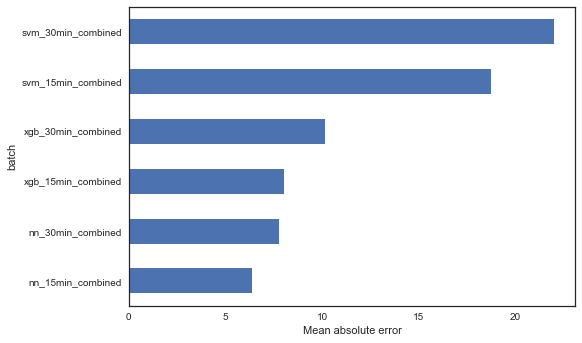

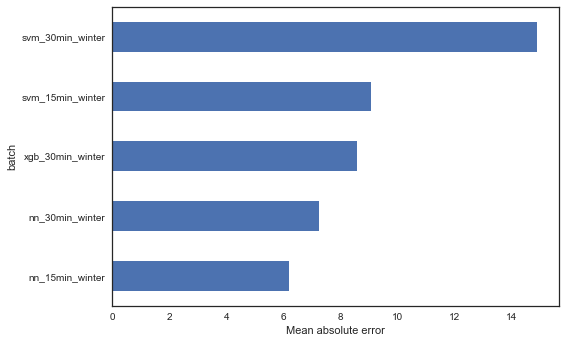

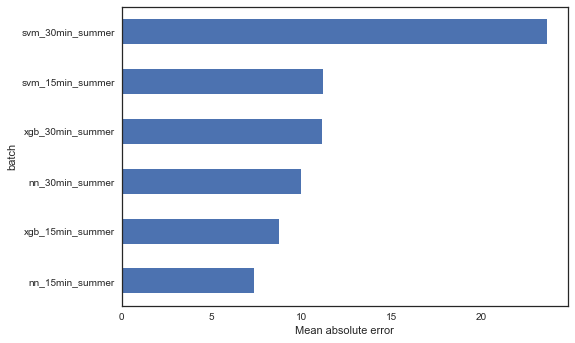

In [219]:
# Possible to recover overall MAE from the weighted n?
batches = list()
models = list()
seasons = list()
maes = list()
for batch in perf_weights['batch'].unique():
    dat = perf_weights.loc[perf_weights['batch']==batch,]
    total_n = dat['n'].sum()
    mae = (dat['mae'] * dat['n']).sum() / total_n
    batches.append(batch)
    models.append(batch.split("_")[0])
    seasons.append(batch.split("_")[-1])
    maes.append(mae)

dat = pd.DataFrame({
    'batch': batches,
    'model': models,
    'season': seasons,
    'mae': maes
}).sort_values('mae')

dat.loc[dat['season']=='combined'].set_index('batch')['mae'].plot.barh()
plt.xlabel("Mean absolute error")
plt.show()

dat.loc[dat['season']=='winter'].set_index('batch')['mae'].plot.barh()
plt.xlabel("Mean absolute error")
plt.show()

dat.loc[dat['season']=='summer'].set_index('batch')['mae'].plot.barh()
plt.xlabel("Mean absolute error")
plt.show()